# Global & local vertical scale estimation

## Summary

Process results of progressive hypsometry (PH) for a collection of regions and their ensemble of "supercatchments" to identify the global and local vertical scales of each. 

Each supercatchments PH data file provides a set of $h_\mathrm{outlet}$ and $h_\mathrm{bench}$ values in tab-separated form. This table of PHBs (progressive hypsometry benches) is converted into an vector of $\Delta{h} = h_\mathrm{bench}-h_\mathrm{outlet}$ values.

Kernel density estimation is used to compute a smooth frequency distribution (pdf) of $\Delta{h}$ assuming a Gaussian kernel with a Silverman bandwidth (narrowed by 75%).

The peaks of this distribution, which are the modes of the pdf, are located, and the largest two, which likely constitute the global and local vertical scales, are chosen.

The kde pdf is then modeled through least-squares curve-fitting using two Gaussians, whose means are initiated at these two modes respectively, and whose means, standard deviations and relative magnitude are permitted to vary.

The result is an estimate of the global and local scales and their spread (one standard deviation) for each supercatchment. These results are gathered into one summary table and exported as a text file.

Graphs are plotted to record the kde pdf, the Gaussian-modeled pdf, the raw kde pdf modes and the Gaussian modeled modes aka global and local vertical scales.

### Prerequisites

To run this notebook you’ll need to have installed (with `Conda`, `pip` or other package manager) the following packages:
  - numpy
  - scipy
  - matplotlib
  - os
  - pandas
  - sklearn
  - json

### How to run

1. Open a terminal
2. Assuming you are running `bash`, type: 
    - `export PHHOME="${HOME}/Science/ProgHypso"` 
    - or whatever your path to the parent for `PHscales` is
3. `cd` to the directory containing the notebook
4. Type `jupyter-notebook`, or to choose a specific version, e.g.  `jupyter-notebook-3.7`
5. `Cell` -> `Run all`

## Parameters

In [1]:
phbs_groups = [
    ['Ac0p1km2','PHBs','Cusum02_BenchLength3Steps','Tables'],
    ['Ac0p5km2','PHBs','Cusum02_BenchLength3Steps','Tables'] 
]
example_phb_index = 2

In [2]:
# bandwidth_adjustment_factor = 0.75
bandwidth_adjustment_factor = 1
bandwidth_adjustment_factor
default_gaussian_stdev = 20

1

## Preliminaries

In [3]:
import json, os, pandas as pd, numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.neighbors.kde import KernelDensity
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.stats import norm
# from IPython.core.interactiveshell import InteractiveShell

In [4]:
ph_home_path=os.getenv('PHHOME',
                os.path.join(os.getenv('HOME'),'Science','ProgHypso'))
if ph_home_path is None:
    ph_home_path=os.path.join(os.getenv('HOME'),'Science','ProgHypso')
ph_scales_path = os.path.join(ph_home_path,'PHscales')

In [5]:
# figsize = [6, 8]
figsize = [8, 6]
mpl.rc( 'figure', autolayout=False,  titlesize='Large',dpi=100)
mpl.rc( 'lines', linewidth=2.0, markersize=8)
mpl.rc( 'font', size=12, family='Arial')
mpl.rc( 'axes', labelsize=12) 

## Methods

In [6]:
def read_data(dir_name=('.'), file_name=None, 
              file_ext='', key='ph', sep='\t',
              index_col=0, header=0, skip_rows=None):
    """
    """
    dir_name = os.path.join(*dir_name)
    if not os.path.exists(dir_name):
        print('Cannot find data directory')
        raise
    try:
        file_path = os.path.join(dir_name,file_name+file_ext)
        df = pd.read_csv(file_path, sep=sep,
                           index_col=index_col, header=header, 
                           skiprows=skip_rows) 
    except OSError:  
        print('Cannot read data file {}'.format(file_path))
        raise
    except:  
        raise
    return df

In [7]:
def bimodal_model(x,x0,s0,a0,x1,s1):
    return ( a0*norm.pdf(x, loc=x0,scale=s0)
            +(1-a0)*norm.pdf(x, loc=x1,scale=s1) )

In [8]:
def trimodal_model(x,x0,s0,a0,x1,s1,a1,x2,s2):
    return ( a0*norm.pdf(x, loc=x0,scale=s0)
            +a1*norm.pdf(x, loc=x1,scale=s1)
            +(1-a0-a1)*norm.pdf(x, loc=x2,scale=s2) )

In [9]:
def compute_kde_pdf(phbs_dict, phb, verbose=False):
    raw_df = phbs_dict[phb]['raw_df']
    data = np.array(raw_df['Delta_h']).reshape(-1,1)
    Delta_h_array = np.linspace(0,1.2*np.max(data),200)
    bw = data.std()*(4/3/data.size)**(1/5)*bandwidth_adjustment_factor
    if verbose:
        print('{}:  bandwidth = {:.0f}'.format(phb,bw))
    kde = KernelDensity(kernel='gaussian', bandwidth=bw)
    kde.fit(data)
    kde_array = np.exp(kde.score_samples(Delta_h_array.reshape(-1,1)))
    kde_df = pd.DataFrame(index=None,
                          data={'Delta_h': Delta_h_array,
                                'p_Delta_h': kde_array})
    phbs_dict[phb].update({'kde_df':kde_df})

In [10]:
def find_modes(phbs_dict, phb, verbose=False):
    kde_df = phbs_dict[phb]['kde_df']
    Delta_h_array = kde_df['Delta_h']
    p_Delta_h_array = kde_df['p_Delta_h']
    peaks_array = find_peaks(p_Delta_h_array)[0]
    peaks_array = np.vstack((peaks_array,
                             Delta_h_array[peaks_array],
                             p_Delta_h_array[peaks_array])).T
    # Sort by magnitude (largest p(∆h) first)
    peaks_array = np.flipud(peaks_array[peaks_array[:,2].argsort()])
    principal_modes_array = peaks_array[:,1:3]
    phbs_dict[phb].update({'modes':principal_modes_array})
    if verbose:
        print(phb)
        print('Principal mode#1: ∆h={:.0f}m  p(∆h)={:.5f}'
              .format(principal_modes_array[0,0],principal_modes_array[0,1]))
        print('Principal mode#2: ∆h={:.0f}m  p(∆h)={:.5f}'
              .format(principal_modes_array[1,0],principal_modes_array[1,1]))
        if principal_modes_array.shape[0]>2:
            print('Principal mode#3: ∆h={:.0f}m  p(∆h)={:.5f}'
              .format(principal_modes_array[2,0],principal_modes_array[2,1]))
        print('')

In [11]:
def fit_bimodal(phbs_dict, phb, verbose=False):
    kde_df          = phbs_dict[phb]['kde_df']
    modes_array     = phbs_dict[phb]['modes']
    Delta_h_array   = kde_df['Delta_h']
    p_Delta_h_array = kde_df['p_Delta_h']
    initial_values  = [modes_array[0,0], default_gaussian_stdev, 0.5,
                       modes_array[1,0], default_gaussian_stdev]
    popt,pcov = curve_fit(bimodal_model, 
                          Delta_h_array, p_Delta_h_array, 
                          p0=initial_values)
    scales_array = np.zeros((2,8))
    scales_array[0,:] = [popt[0],popt[1],
                         bimodal_model(popt[0],*popt),
                         *popt]
    scales_array[1,:] = [popt[3],popt[4],
                         bimodal_model(popt[3],*popt),
                         *popt]
    scales_array = np.flipud(scales_array[scales_array[:,0].argsort()])
    phbs_dict[phb].update({'bimodal_scales': scales_array})
    phbs_dict[phb].update({'bimodal_pdf': bimodal_model(Delta_h_array,*popt)})
    if verbose:
        print(phb)
        print('Global vertical scale: H_G = {:.0f} ± {:.0f}m  p(∆h)={:0.5f}'
              .format(*list(scales_array[0,:])))
        print('Local vertical scale:  H_L = {:.0f} ± {:.0f}m  p(∆h)={:0.5f}'
              .format(*list(scales_array[1,:])))
        print()

In [12]:
def fit_trimodal(phbs_dict, phb, verbose=False):
    kde_df          = phbs_dict[phb]['kde_df']
    modes_array     = phbs_dict[phb]['modes']
    Delta_h_array   = kde_df['Delta_h']
    p_Delta_h_array = kde_df['p_Delta_h']
    if modes_array.shape[0]>2:
        initial_values  = [modes_array[0,0], default_gaussian_stdev, 0.5,
                           modes_array[1,0], default_gaussian_stdev, 0.4,
                           modes_array[2,0], default_gaussian_stdev]
        popt,pcov = curve_fit(trimodal_model, 
                              Delta_h_array, p_Delta_h_array, 
                              p0=initial_values)

        scales_array = np.zeros((3,11))
        scales_array[0,:] = [popt[0],popt[1],
                             trimodal_model(popt[0],*popt),
                             *popt]
        scales_array[1,:] = [popt[3],popt[4],
                             trimodal_model(popt[3],*popt),
                             *popt]
        scales_array[2,:] = [popt[6],popt[7],
                             trimodal_model(popt[6],*popt),
                             *popt]  
        scales_array=np.flipud(scales_array[scales_array[:,0].argsort()])
        phbs_dict[phb].update({'trimodal_scales': scales_array})
        if verbose:
            print(phb)
            print('Global vertical scale: H_G = {:.0f} ± {:.0f}m'
                  .format(scales_array[0,0],scales_array[0,1]))
            print('Local vertical scale:  H_L = {:.0f} ± {:.0f}m'
                  .format(scales_array[1,0],scales_array[2,1]))
            print('Extra vertical scale:  H_X = {:.0f} ± {:.0f}m'
                  .format(scales_array[2,0],scales_array[1,1]))
        print()
    else:
        phbs_dict[phb].update({'trimodal':(None,None)})
        if verbose:
            print(phb)
            print('Two modes only resolved')
            print()


## Graphics

In [13]:
def plot_pdf(phbs_dict, phb):
    kde_df          = phbs_dict[phb]['kde_df']
    modes_array     = phbs_dict[phb]['modes']
    Delta_h_array   = kde_df['Delta_h']
    p_Delta_h_array = kde_df['p_Delta_h']
    bimodal_scales_array  = phbs_dict[phb]['bimodal_scales']
    bimodal_pdf_array  = phbs_dict[phb]['bimodal_pdf']

    figure = plt.figure(figsize=figsize);
    plt.plot(Delta_h_array,p_Delta_h_array, 
             c='k', lw=1, label='kde pdf');
    plt.plot(Delta_h_array,bimodal_pdf_array,
             '-', lw=2, c='DarkGreen', label='bimodal fit');
    plt.plot(bimodal_scales_array[0,0],bimodal_scales_array[0,2],
             'o',ms=8,c='DarkGreen',fillstyle='full', 
             label='$H_G = ${:.0f} $\pm$ {:.0f}m'
             .format(np.round(bimodal_scales_array[0,0]),
                     np.round(bimodal_scales_array[0,1])));
    plt.plot(bimodal_scales_array[1,0],bimodal_scales_array[1,2],
             's',ms=8,c='DarkGreen',fillstyle='full', 
             label='$H_L = ${:.0f} $\pm$ {:.0f}m'
             .format(np.round(bimodal_scales_array[1,0]),
                     np.round(bimodal_scales_array[1,1])));
    x_max = np.max(Delta_h_array)
    axes = plt.gca()
    axes.set_xlim(0,x_max);
    axes.set_ylim(0,)
    axes.set_xlabel('$\Delta{h}$  [m]')
    axes.set_ylabel('$p(\Delta{h})$')
    if bimodal_scales_array[0,2]>bimodal_scales_array[1,2]:
        loc='upper left'
    else:
        loc='upper right'
    plt.legend(fontsize=12,loc=loc)
    plt.title(phb);
    phbs_dict[phb].update({'fig_bimodal_pdf': figure})

## Data

In [14]:
region_dict = {}
for dir in os.listdir(ph_scales_path):
    path = os.path.realpath(os.path.join(ph_scales_path,dir))
    if dir[0]!='.' and dir!='Analysis' and os.path.isdir(path):
        region_dict.update({dir : path})
region_dict 

{'CostaRica': '/Users/colinstark/Science/ProgHypso/PHscales/CostaRica',
 'Finisterres': '/Users/colinstark/Science/ProgHypso/PHscales/Finisterres',
 'GabilanMesa': '/Users/colinstark/Science/ProgHypso/PHscales/GabilanMesa',
 'SanGabriel': '/Users/colinstark/Science/ProgHypso/PHscales/SanGabriel',
 'SantaMarta': '/Users/colinstark/Science/ProgHypso/PHscales/SantaMarta'}

In [15]:
supercatchment_dict = {}
for phbs_group in phbs_groups:
    for region in region_dict:
        path = os.path.join(region_dict[region],*phbs_group)
        if os.path.isdir(path):
            supercatchment_list = [
                (path,supercatchment)
                for supercatchment in os.listdir(path) 
                if supercatchment[0]!='.']
            supercatchment_dict.update({region : supercatchment_list})
supercatchment_dict

{'GabilanMesa': [('/Users/colinstark/Science/ProgHypso/PHscales/GabilanMesa/Ac0p1km2/PHBs/Cusum02_BenchLength3Steps/Tables',
   'Supercatchment1_allOutletModePairs.txt'),
  ('/Users/colinstark/Science/ProgHypso/PHscales/GabilanMesa/Ac0p1km2/PHBs/Cusum02_BenchLength3Steps/Tables',
   'Supercatchment2_allOutletModePairs.txt')],
 'CostaRica': [('/Users/colinstark/Science/ProgHypso/PHscales/CostaRica/Ac0p5km2/PHBs/Cusum02_BenchLength3Steps/Tables',
   'Supercatchment11_allOutletModePairs.txt'),
  ('/Users/colinstark/Science/ProgHypso/PHscales/CostaRica/Ac0p5km2/PHBs/Cusum02_BenchLength3Steps/Tables',
   'Supercatchment16_allOutletModePairs.txt'),
  ('/Users/colinstark/Science/ProgHypso/PHscales/CostaRica/Ac0p5km2/PHBs/Cusum02_BenchLength3Steps/Tables',
   'Supercatchment19_allOutletModePairs.txt'),
  ('/Users/colinstark/Science/ProgHypso/PHscales/CostaRica/Ac0p5km2/PHBs/Cusum02_BenchLength3Steps/Tables',
   'Supercatchment1_allOutletModePairs.txt'),
  ('/Users/colinstark/Science/ProgHypso/

In [16]:
phbs_dict = {}

In [17]:
for supercatchment in supercatchment_dict.keys():
    for phbs in supercatchment_dict[supercatchment]:
        name = supercatchment+'_'+phbs[1].replace('.txt','')
        path = (phbs[0],phbs[1])
        df = read_data(dir_name=[phbs[0]], 
                          file_name=phbs[1], index_col=None)
        phbs_dict.update({name : {'path':phbs[0],
                                  'file':phbs[1],
                                  'raw_df':  df} })

list(phbs_dict.keys())

['GabilanMesa_Supercatchment1_allOutletModePairs',
 'GabilanMesa_Supercatchment2_allOutletModePairs',
 'CostaRica_Supercatchment11_allOutletModePairs',
 'CostaRica_Supercatchment16_allOutletModePairs',
 'CostaRica_Supercatchment19_allOutletModePairs',
 'CostaRica_Supercatchment1_allOutletModePairs',
 'CostaRica_Supercatchment24_allOutletModePairs',
 'CostaRica_Supercatchment30_allOutletModePairs',
 'CostaRica_Supercatchment9_allOutletModePairs',
 'Finisterres_Supercatchment12_allOutletModePairs',
 'Finisterres_Supercatchment18_allOutletModePairs',
 'Finisterres_Supercatchment33_allOutletModePairs',
 'Finisterres_Supercatchment37_allOutletModePairs',
 'SanGabriel_Supercatchment132_allOutletModePairs',
 'SantaMarta_Supercatchment19_allOutletModePairs']

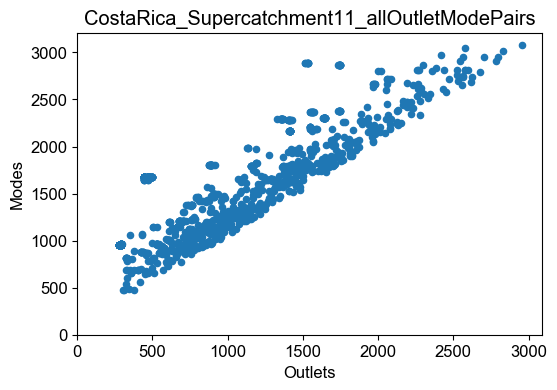

In [18]:
example_phb = list(phbs_dict.keys())[example_phb_index]
df = phbs_dict[example_phb]['raw_df']
axes = df.plot.scatter(x='Outlets',y='Modes',title=example_phb)
axes.set_xlim(0,);
axes.set_ylim(0,);

## Analysis

For every supercatchment result table (now in a `pandas` dataframe), compute $\Delta{h} = h_\mathrm{mode}-h_\mathrm{outlet}$ and put into a new column in that dataframe.

In [19]:
for phb in phbs_dict:
    df = phbs_dict[phb]['raw_df']
    df['Delta_h'] = df['Modes']-df['Outlets']

Check the pdf $p(\Delta{h})$ for an example super.

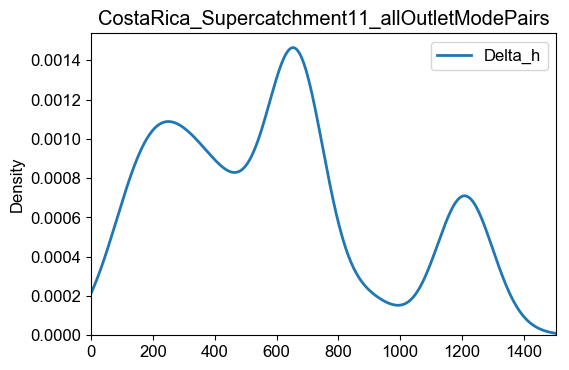

In [20]:
example_phb = list(phbs_dict.keys())[example_phb_index]

df = phbs_dict[example_phb]['raw_df']
axes = df.plot.density(x='Outlets',y='Delta_h',bw_method='silverman',
                          title=example_phb)
axes.set_xlim(0,1.1*np.max(df['Delta_h']));
axes.set_ylim(0,);

Compute a kernel-density estimated pdf for each super, and place in another dataframe for each.

In [21]:
for phb in phbs_dict:
    compute_kde_pdf(phbs_dict, phb)

For the example super, compare this kde pdf with the one generated and plotted above by `pandas`.

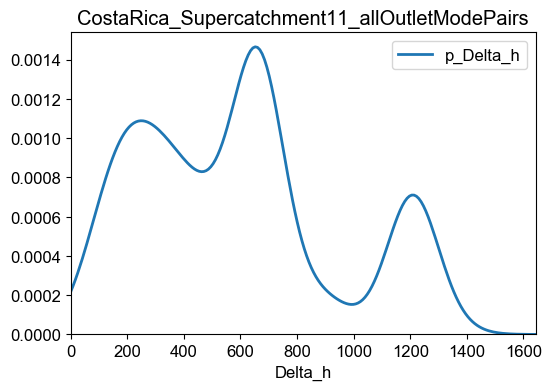

In [22]:
example_phb = list(phbs_dict.keys())[example_phb_index]
df = phbs_dict[example_phb]['kde_df']
axes = df.plot.line(x='Delta_h',y='p_Delta_h',
                          title=example_phb)
axes.set_xlim(0,np.max(df['Delta_h']));
axes.set_ylim(0,);

In [23]:
for phb in phbs_dict:
    modes = find_modes(phbs_dict, phb)

In [24]:
for phb in phbs_dict:
    fit_bimodal(phbs_dict, phb)

In [25]:
for phb in phbs_dict:
    fit_trimodal(phbs_dict, phb)

## Plotting

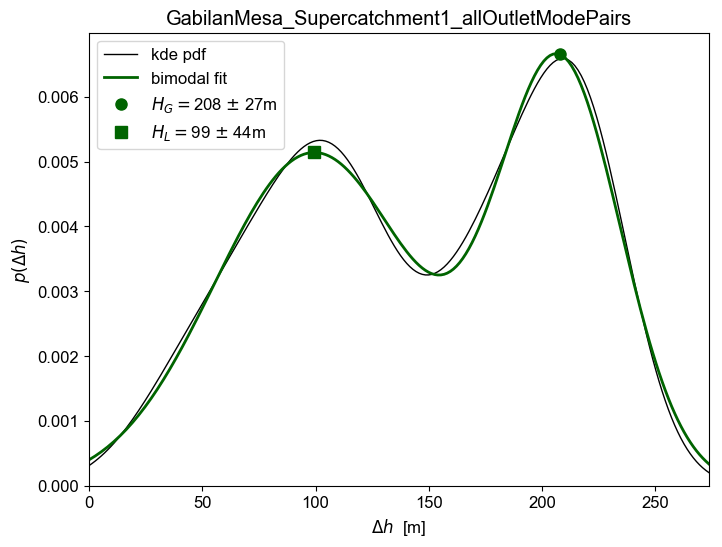

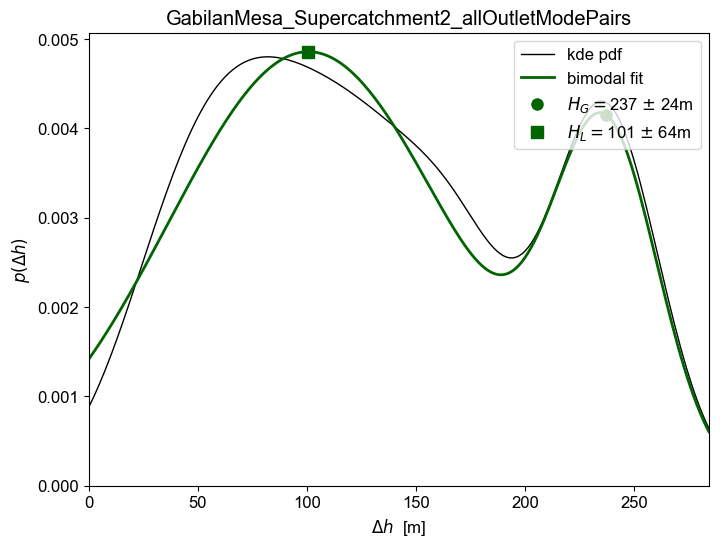

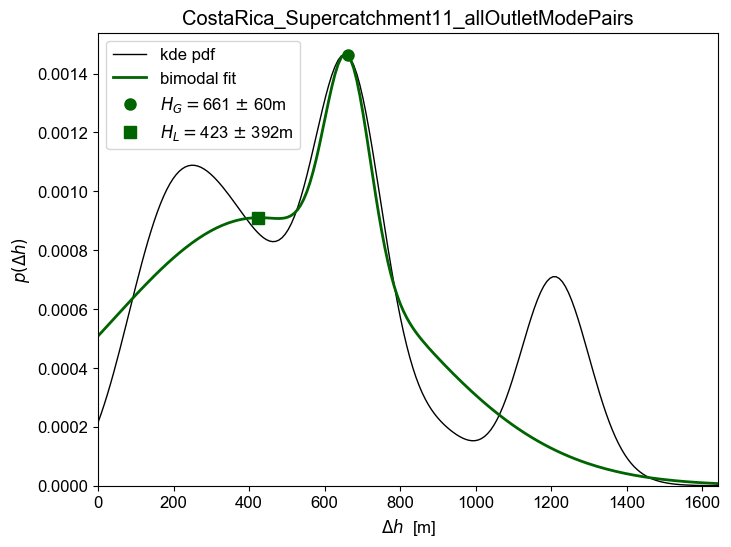

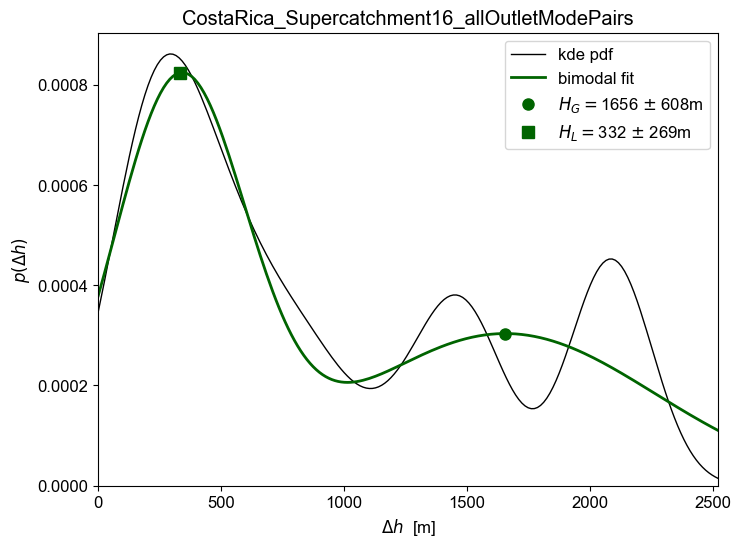

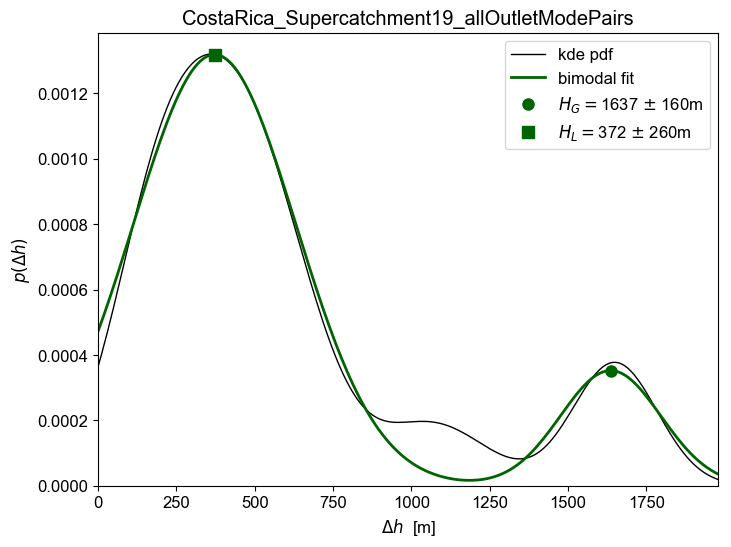

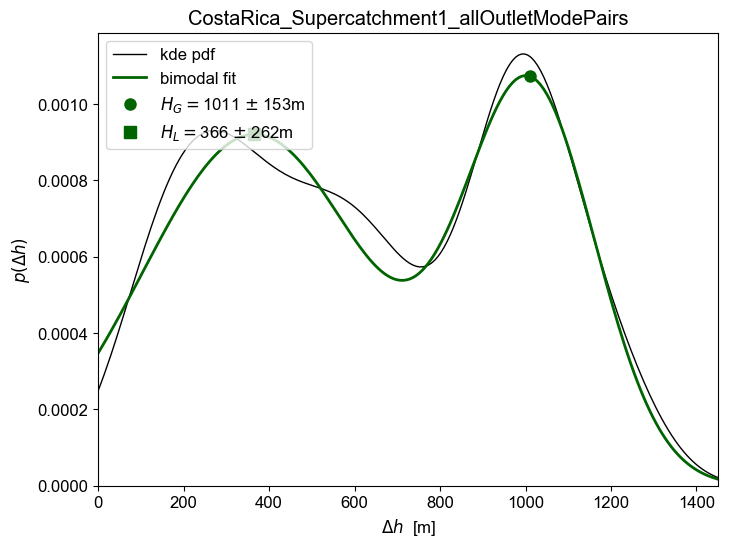

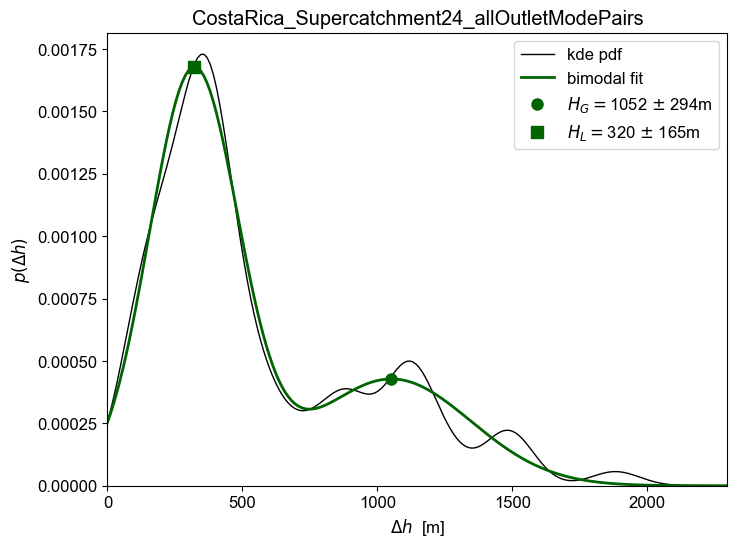

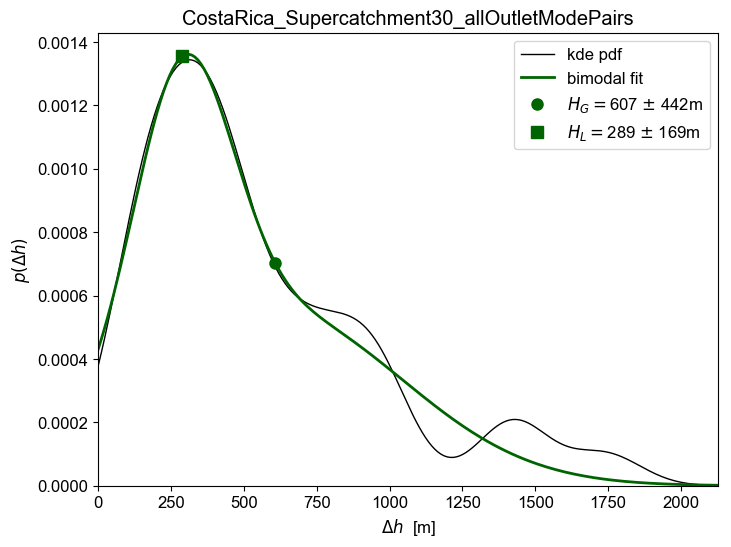

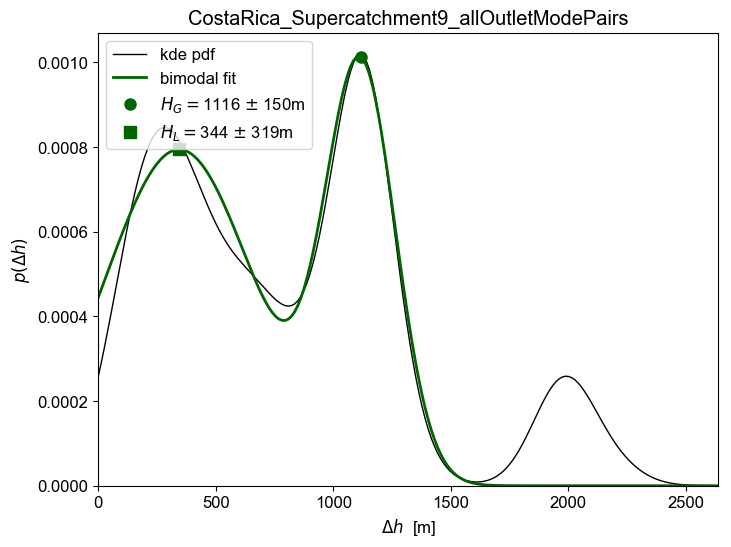

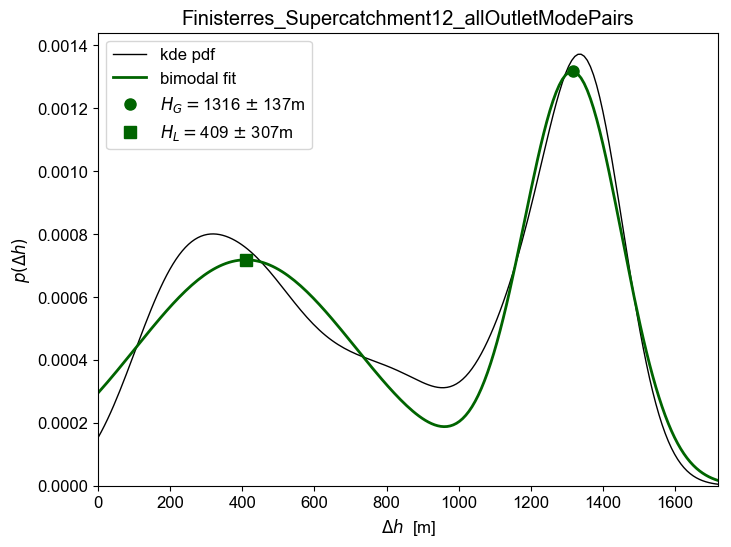

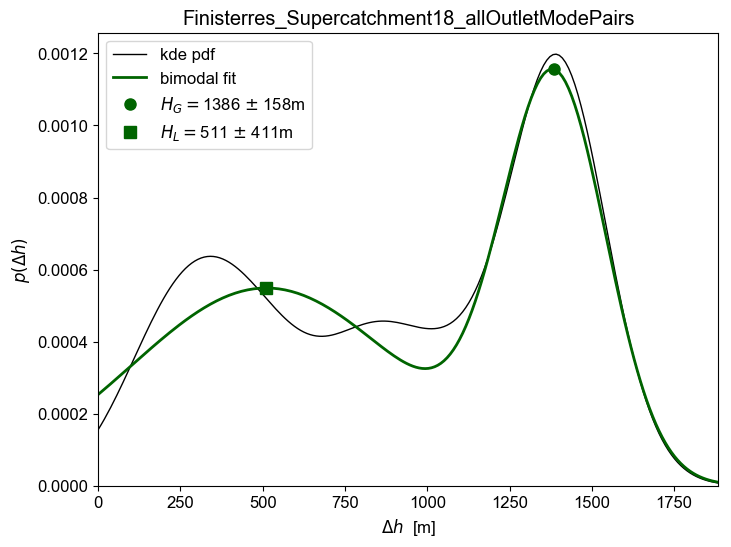

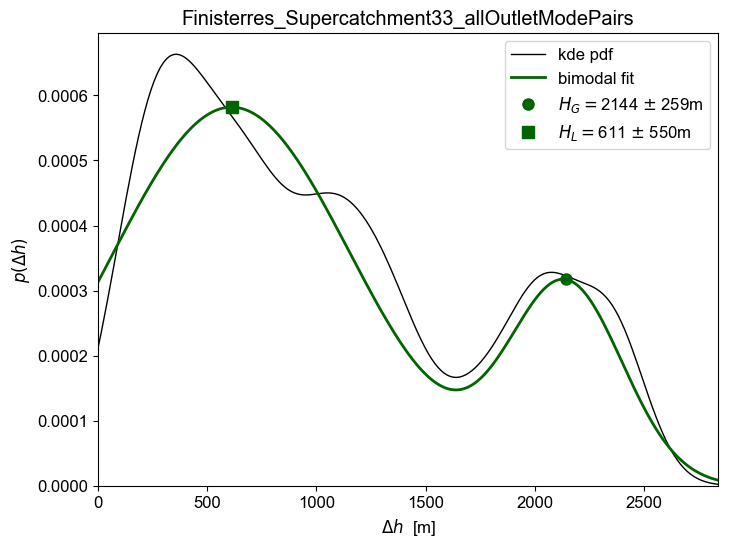

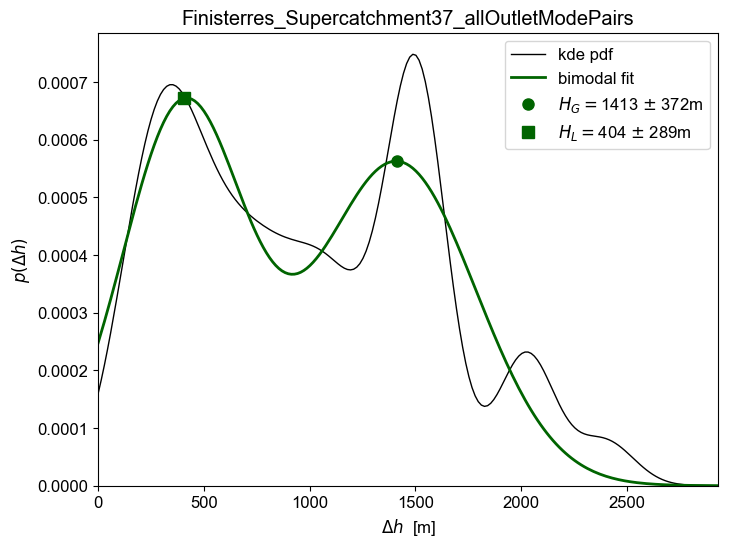

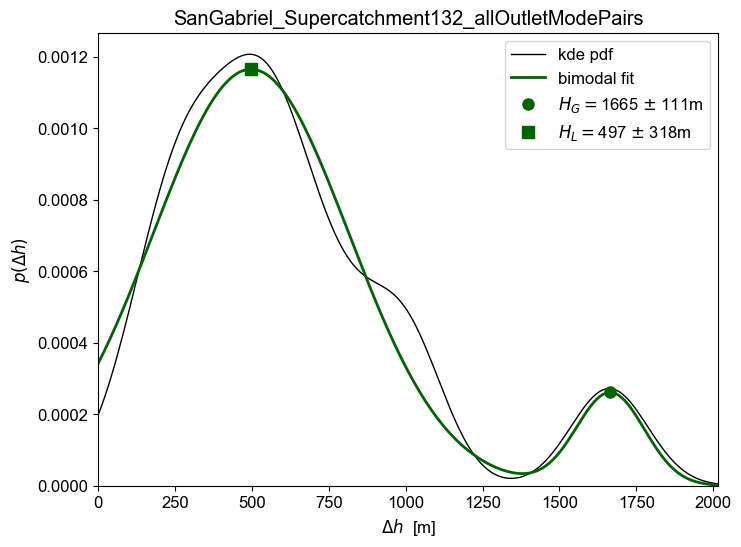

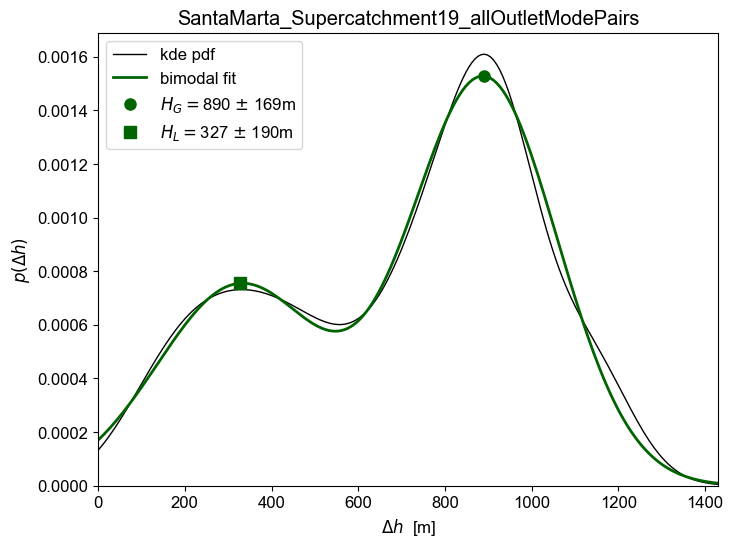

In [26]:
for phb in phbs_dict:
    plot_pdf(phbs_dict, phb);

In [27]:
# example_phb = list(phbs_dict.keys())[example_phb_index]
# plot_pdf(phbs_dict,example_phb);

## Export